In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adaboost import *
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import datetime
from joblib import Parallel, delayed
import deepdish as dd
import joblib
import warnings

因子IC统计 20天训练再加权 kmeans聚类降噪

In [2]:
# data = scipy.io.loadmat('factorZScore.mat')
# quantile = scipy.io.loadmat('yQuantile.mat')
# X = pd.DataFrame(data['factorZScore'])
# y = pd.DataFrame(quantile['yQuantile'])

# X[0] = X[0].apply(lambda x:str(int(x)))
# y[0] = y[0].apply(lambda x:str(int(x)))

# X[0] = X[0].apply(lambda x:datetime.datetime(int(x[:4]),int(x[4:6]),int(x[6:8])))
# y[0] = y[0].apply(lambda x:datetime.datetime(int(x[:4]),int(x[4:6]),int(x[6:8])))

# X.pop(1)
# y.pop(1)
# X.set_index(0,inplace=True)
# y.set_index(0,inplace=True)
# y.rename(columns={2:'origin'},inplace=True)
# positive = y.origin <= 0.3
# negative = y.origin >= 0.8
# y['label'] = 0
# y.loc[positive,'label'] = 1
# y.loc[negative,'label'] = -1

# X['label'] = 0
# X.loc[positive,'label'] = 1
# X.loc[negative,'label'] = -1

# X = X.loc[X.label != 0,:]
# y = y.loc[y.label != 0,:]
# X.pop('label')

In [3]:
def get_data():
    dict = dd.io.load('D:\Project\lianhai\FactorData.h5')
    df_list = []
    for key in dict.keys():
        temp = dict[key]
        temp_df = pd.DataFrame(temp['Factor'],index=np.arange(1,41),columns=temp['StockCode'][0]).T
        temp_df['return'] = temp['ReturnDaily'][0]
        temp_df['date'] = key
        df_list.append(temp_df.reset_index().rename(columns={'index':'stockcode'}))
    return pd.concat(df_list)

In [4]:
data = get_data()

In [5]:
ic = data.iloc[:,1:42].corr()['return']

In [6]:
# data.pop('stockcode')
# data.date = data.date.apply(lambda x:datetime.datetime(int(x[:4]),int(x[4:6]),int(x[6:8])))
# data = data.loc[data.date >= datetime.datetime(2020,4,11)]
# data.set_index('date',inplace=True)
# time_list = data.index.unique()
# data['cluster'] = np.nan

In [7]:
# for i in range(30,41):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(data.dropna(axis=1))
#     print('i:'.format(i),calinski_harabasz_score(data.dropna(axis=1),kmeans.labels_))

In [8]:
# for i in range(10,30):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(data.dropna(axis=1))
#     data['cluster'] = kmeans.labels_
#     print('i:'.format(i),calinski_harabasz_score(data.dropna(axis=1),kmeans.labels_))

In [9]:
def process_data(data, kmeans=False):
    # kmeans：是否根据因子值进行kmeans聚类对收益率降噪
    # 每日前30%收益率标记为+1，每日后30%收益率标记为-1，舍弃中间40%的数据
    # kmeans的超参数n_clusters是基于长期数据根据calinski_harabasz_score进行挑选的
    data.date = data.date.apply(lambda x:datetime.datetime(int(x[:4]),int(x[4:6]),int(x[6:8])))
    # 此处取了2020.4以后的数据
    data = data.loc[data.date >= datetime.datetime(2020,4,11)]
    data.set_index('date',inplace=True)
    time_list = data.index.unique()
    if kmeans:
        data['cluster'] = np.nan
        for time in time_list:
            kmeans = KMeans(n_clusters=29)
            kmeans.fit(data.loc[data.index == time].dropna(axis=1))
            data.loc[data.index == time,'cluster'] = kmeans.labels_ + 1
            temp = data.loc[data.index == time]
            for c in range(1,11):
                temp.loc[temp.cluster == c,'return'] = temp.groupby('cluster').mean().loc[c,'return']
        data.pop('cluster')
    data['label'] = 0
    def do_label(x,inf,sup):
        if x >= sup:
            return 1
        elif x <= inf:
            return -1
        else:
            return 0
    for date in time_list:
        temp = data[data.index == date]
        inf = temp['return'].quantile(0.3)
        sup = temp['return'].quantile(0.7)
        data.loc[data.index == date,'label'] = temp['return'].apply(lambda x :do_label(x,inf,sup))
    return data.loc[data.label != 0,:]

In [10]:
warnings.filterwarnings('ignore')
data = process_data(data)

In [11]:
X = data[np.arange(1,41)]
y = data[['stockcode','label','return']]

In [12]:
a = X.index.nunique()
d = 20
t = a // d
k = 3

In [13]:
# temp = X.index.unique()[-1]
# X_temp = X.loc[X.index>=temp]
# y_temp = y.loc[y.index>=temp]
# x_train,x_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.1,random_state=0)
# model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=.3,k=1/50,n_estimators=200,early_stop=True)
# model.fit(x_train,y_train[['label']],y_train['return'],x_val,y_val)
# model.plot(x_val,y_val[['label']],y_val['return'])

In [14]:
y['pred'] = np.nan
y['prob'] = np.nan

In [15]:
def daily_model(X,y):
    def subjob_func(i):
        temp = X.index.unique()[i]
        X_temp = X.loc[X.index==temp]
        y_temp = y.loc[y.index==temp]
        x_train,x_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.1,random_state=i)
        model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=.3,k=0.025,n_estimators=100,early_stop=True)
        model.fit(x_train,y_train[['label']],y_train['return'],x_val,y_val)
        # model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_split=0.1),n_estimators=80,learning_rate=.3)
        # model.fit(x_train,y_train[['label']])
        return model
    models = Parallel(n_jobs=5)(delayed(subjob_func)(i) for i in range(a))
    return models
def daily_factor(models,Y):
    y = Y.copy(deep=True)
    for i in range(0,a-d):
        time = X.index.unique()[i+d]
        prob_list = []
        for j in range(d):
            prob_list.append(models[i+j].predict_proba(X.loc[X.index==time]))
        w = [0.95**i for i in range(d-1,-1,-1)]
        y.loc[y.index==time,'prob'] = np.dot(np.matrix(prob_list).T,np.array(w)).tolist()[0]
    return y
# models = daily_model(X,y)

In [16]:
# y1 = daily_factor(models,y)
y1 = pd.read_csv('60_daily_factor',index_col='date')
y1.index = pd.to_datetime(y1.index)

In [17]:
def monthly_model_caculate(X,y):
    def subjob_func(i):
        time_start = X.index.unique()[i]
        time_end = X.index.unique()[i+d-1]
        X_temp = X.loc[(X.index>=time_start)&(X.index<=time_end)]
        y_temp = y.loc[(y.index>=time_start)&(y.index<=time_end)]
        x_train,x_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.1,random_state=i)
        model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=.1,k=.0105,n_estimators=200,early_stop=True)
        model.fit(x_train,y_train[['label']],y_train['return'],x_val,y_val)
        return model
    res = Parallel(n_jobs=5)(delayed(subjob_func)(i) for i in range(0,a-d))
    return res
def daily_factor_caculate(models,Y):
    y = Y.copy(deep=True)
    for i in range(0,a-k*d):
        time = X.index.unique()[i+k*d]
        prob_list = []
        for j in range(k):
            prob_list.append(models[i+j].predict_proba(X.loc[X.index==time]))
        # w = [0.95**i for i in range(k-1,-1,-1)]
        w = [1/k for _ in range(k)]
        y.loc[X.index==time,'prob'] = np.dot(np.matrix(prob_list).T,np.array(w)).tolist()[0]
    return y
# models = monthly_model_caculate(X,y)
# 保存模型
# joblib.dump(models,'models.dat') 
# 55 mins

In [18]:
# models = joblib.load('models.dat')

In [19]:
# y3 = daily_factor_caculate(models,y)
# y3.to_csv('20_3_factor')

In [ ]:
y3 = pd.read_csv('20_3_factor',index_col='date')
y3.index = pd.to_datetime(y2.index)

In [20]:
y2 = pd.read_csv('60_monthly_factor',index_col='date')
y2.index = pd.to_datetime(y2.index)

In [21]:
def monthly_model_predict(x,Y):
    X = x.copy(deep=True)
    y = Y.copy(deep=True)
    def subjob_func(i):
        time_start = X.index.unique()[i]
        time_end = X.index.unique()[i+d-1]
        time = X.index.unique()[i+d]
        X_temp = X.loc[(X.index>=time_start)&(X.index<=time_end)]
        y_temp = y.loc[(y.index>=time_start)&(y.index<=time_end)]
        x_train,x_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.1,random_state=i)
        model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=.1,k=.0105,n_estimators=200,early_stop=True)
        model.fit(x_train,y_train[['label']],y_train['return'],x_val,y_val)
        return model.predict_proba(X.loc[X.index==time])
    res = Parallel(n_jobs=5)(delayed(subjob_func)(i) for i in range(0,a-d))
    for i in range(0,a-d):
        time = X.index.unique()[i+d]
        y.loc[X.index==time,'prob'] = res[i]
    return y
# y2 = monthly_model_predict(X,y)

In [22]:
y_test_1 = y1.loc[~y1.prob.isna(),:].copy(deep=True)
y_test_2 = y2.loc[~y2.prob.isna(),:].copy(deep=True)
y_test_3 = y3.loc[~y3.prob.isna(),:].copy(deep=True)
# y_test_1['pred'] = y_test_1.prob.apply(lambda x:-1 if x <= 6.415 else 1)
y_test_1['pred'] = y_test_1.prob.apply(lambda x:-1 if x <= 9.54 else 1)
y_test_2['pred'] = y_test_2.prob.apply(lambda x:-1 if x <= 0.5 else 1)
y_test_3['pred'] = y_test_3.prob.apply(lambda x:-1 if x <= 0.5 else 1)

In [36]:
y_test_1 = y_test_1.loc[y_test_1.index >= datetime.datetime(2020,7,13)]
y_test_2 = y_test_2.loc[y_test_2.index >= datetime.datetime(2020,7,13)]

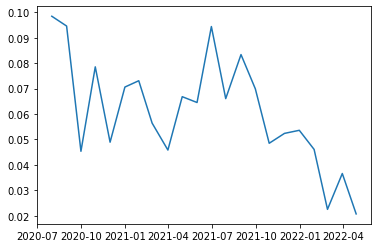

In [37]:
plt.plot(y_test_1.resample('BM')[['return','prob']].corr(method='spearman').unstack()['return']['prob']);

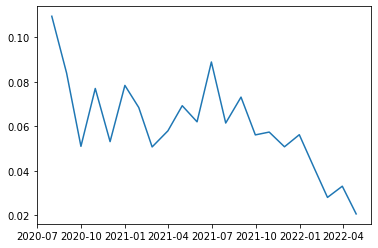

In [38]:
plt.plot(y_test_2.resample('BM')[['return','prob']].corr(method='spearman').unstack()['return']['prob']);

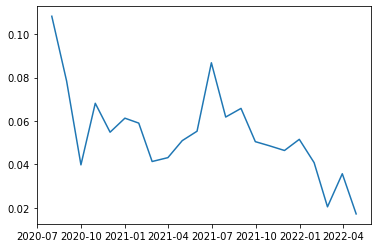

In [39]:
plt.plot(y_test_3.resample('BM')[['return','prob']].corr(method='spearman').unstack()['return']['prob']);

In [40]:
y_test_1[['return','prob']].corr(method='spearman')

,return,prob
return,1.000000,0.063142
prob,0.063142,1.000000


In [41]:
y_test_2[['return','prob']].corr(method='spearman').iloc[0,1]

0.06108080883243942

In [42]:
y_test_3[['return','prob']].corr(method='spearman')

,return,prob
return,1.000000,0.054675
prob,0.054675,1.000000


In [43]:
accuracy_score(y_true=y_test_1.label,y_pred=y_test_1.pred)

0.5265388056215378

In [44]:
accuracy_score(y_true=y_test_2.label,y_pred=y_test_2.pred)

0.5289846769466712

In [45]:
accuracy_score(y_true=y_test_3.label,y_pred=y_test_3.pred)

0.525410619929224

In [46]:
confusion_matrix(y_true=y_test_1.label,y_pred=y_test_1.pred)

array([[148869,  78044],
       [136825,  90088]], dtype=int64)

In [47]:
confusion_matrix(y_true=y_test_2.label,y_pred=y_test_2.pred)

array([[124532, 102381],
       [111378, 115535]], dtype=int64)

In [48]:
confusion_matrix(y_true=y_test_3.label,y_pred=y_test_3.pred)

array([[123557, 103356],
       [112025, 114888]], dtype=int64)

In [50]:
y_test_3

,stockcode,label,return,pred,prob
date,,,,,
2020-07-13,6.0,-1,-0.019823,-1,0.448563
2020-07-13,8.0,-1,-0.015115,1,0.509199
2020-07-13,9.0,-1,-0.046530,1,0.504889
2020-07-13,12.0,-1,-0.013584,-1,0.488643
2020-07-13,16.0,1,0.010658,-1,0.486771
...,...,...,...,...,...
2022-04-11,605365.0,-1,-0.016762,1,0.504918
2022-04-11,605376.0,1,0.008465,1,0.501738
2022-04-11,605388.0,1,0.039909,-1,0.489615


参数选择

In [ ]:
# best = 0
# cv = pd.DataFrame(index=[0.1,0.2,0.3],columns=np.linspace(1/120,1/80,3))
# for lr in [0.1,0.2,0.3]:
#     for k in np.linspace(1/120,1/80,3):
#         y['pred'] = 0
#         def subjob_func(i):
#             time_start = X.index.unique()[i]
#             time_end = X.index.unique()[i+d-1]
#             time = X.index.unique()[i+d]
#             X_temp = X.loc[(X.index>=time_start)&(X.index<=time_end)]
#             y_temp = y.loc[(y.index>=time_start)&(y.index<=time_end)]
#             x_train,x_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.1,random_state=i)
#             model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=lr,k=k,n_estimators=200,early_stop=True)
#             model.fit(x_train,y_train[['label']],y_train.origin,x_val,y_val)
#             return model.predict(X.loc[X.index==time])
#         res = Parallel(n_jobs=5)(delayed(subjob_func)(i) for i in range(0,120-d))
#         for i in range(0,120-d):
#             time = X.index.unique()[i+d]
#             y.loc[X.index==time,'pred'] = res[i]
#         y_test = y.loc[y.pred != 0,:]
#         ma = accuracy_score(y_true=y_test.label,y_pred=y_test.pred)
#         cv.loc[lr,k] = ma
#         if ma > best:
#             best = ma
#             print('Accuracy:{},parameters: lr={},k={}'.format(ma,lr,k),'best')
#         else:
#             print('Accuracy:{},parameters: lr={},k={}'.format(ma,lr,k))